In [103]:
#Importing all the required libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import pandas as pd
from scipy.linalg import cho_solve, cho_factor
import gpytorch
from datetime import datetime
import torch
from scipy.linalg import cholesky,solve_triangular
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn.model_selection import KFold

In [104]:
#Reading the required files, each dataset is stored in a seperate file and has to be read accordingly
appl_df = pd.read_csv("Historical_Data_APPL.csv")
appl_df.head()

,Date,Close,Volume,Open,High,Low
0,08/09/2024,216.24,42201650,212.10,216.78,211.97
1,08/08/2024,213.31,47161150,213.11,214.20,208.83
2,08/07/2024,209.82,63516420,206.90,213.64,206.39
3,08/06/2024,207.23,69660490,205.30,209.99,201.07
4,08/05/2024,209.27,119548600,199.09,213.50,196.00


In [3]:
#Converting the Date column to the required format
appl_df['Date'] = pd.to_datetime(appl_df['Date'], format='%m/%d/%Y')
appl_df.head()

,Date,Close,Volume,Open,High,Low
0,2024-08-09,216.24,42201650,212.10,216.78,211.97
1,2024-08-08,213.31,47161150,213.11,214.20,208.83
2,2024-08-07,209.82,63516420,206.90,213.64,206.39
3,2024-08-06,207.23,69660490,205.30,209.99,201.07
4,2024-08-05,209.27,119548600,199.09,213.50,196.00


In [4]:
#Making a copy of our dataframe.
model_df = appl_df.copy()

In [5]:
#Sorting the columns by the Daye column in ascending order
model_df = model_df.sort_values(by='Date').reset_index(drop=True)

In [6]:
#Defining the combined Kernel
def combined_kernel(x1, x2, length_scale=1.0, variance=1.0, constant=1.0, linear_variance=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    rbf_part = variance * np.exp(-0.5 * sqdist / length_scale**2)
    constant_part = constant
    linear_part = linear_variance * np.dot(x1, x2.T)
    return rbf_part + constant_part + linear_part

In [41]:
#Defining the same Combined Kernel but this one runs with the help of the GPU, used while GRID SEACRH for faster computing
def combined_kernel2(x1, x2, length_scale=1.0, variance=1.0, constant=1.0, linear_variance=1.0):
    # Ensure inputs are 2D arrays/tensors
    if isinstance(x1, np.ndarray):
        sqdist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
        rbf_part = variance * np.exp(-0.5 * sqdist / length_scale**2)
        linear_part = linear_variance * np.dot(x1, x2.T)
    elif isinstance(x1, torch.Tensor):
        sqdist = torch.sum(x1**2, dim=1).reshape(-1, 1) + torch.sum(x2**2, dim=1) - 2 * torch.matmul(x1, x2.T)
        rbf_part = variance * torch.exp(-0.5 * sqdist / length_scale**2)
        linear_part = linear_variance * torch.matmul(x1, x2.T)
    else:
        raise ValueError("Inputs should be either numpy arrays or torch tensors.")

    constant_part = constant  # Assuming constant is a scalar

    return rbf_part + constant_part + linear_part

In [7]:
#Dividing the dataset into different groups by month to prepare disjointed prior function
model_df = model_df[(model_df['Date'] >= '2015-01-01')]
# Define the start date
start_date = pd.to_datetime('2015-01-01')
# Calculate the number of months since the start date
model_df['Months_Since_Start'] = model_df['Date'].apply(lambda x: (x.year - start_date.year) * 12 + (x.month - start_date.month))
# Create the 'Group' column by dividing the months by 6 and adding 1 (to start from group 1)
model_df['Group'] = (model_df['Months_Since_Start'] // 1) + 1
#Drop the 'Months_Since_Start' column as it's no longer needed
model_df.drop('Months_Since_Start', axis=1, inplace=True)
# Display the dataframe with the new 'Group' column
print(model_df)

           Date     Close     Volume      Open      High       Low  Group
100  2015-01-02   27.3325  212575080   27.8475   27.8600   26.8375      1
101  2015-01-05   26.5625  256843520   27.0725   27.1625   26.3525      1
102  2015-01-06   26.5650  262729000   26.6350   26.8575   26.1575      1
103  2015-01-07   26.9375  159933400   26.8000   27.0500   26.6737      1
104  2015-01-08   27.9725  236675040   27.3075   28.0375   27.1750      1
...         ...       ...        ...       ...       ...       ...    ...
2512 2024-08-05  209.2700  119548600  199.0900  213.5000  196.0000    116
2513 2024-08-06  207.2300   69660490  205.3000  209.9900  201.0700    116
2514 2024-08-07  209.8200   63516420  206.9000  213.6400  206.3900    116
2515 2024-08-08  213.3100   47161150  213.1100  214.2000  208.8300    116
2516 2024-08-09  216.2400   42201650  212.1000  216.7800  211.9700    116

[2417 rows x 7 columns]


In [8]:
# Making a Ordinal Date column to change from date format to integer for calculation purposes

model_df['Date_ordinal'] = model_df['Date'].apply(lambda x: x.toordinal())
print(model_df)

           Date     Close     Volume      Open      High       Low  Group  \
100  2015-01-02   27.3325  212575080   27.8475   27.8600   26.8375      1   
101  2015-01-05   26.5625  256843520   27.0725   27.1625   26.3525      1   
102  2015-01-06   26.5650  262729000   26.6350   26.8575   26.1575      1   
103  2015-01-07   26.9375  159933400   26.8000   27.0500   26.6737      1   
104  2015-01-08   27.9725  236675040   27.3075   28.0375   27.1750      1   
...         ...       ...        ...       ...       ...       ...    ...   
2512 2024-08-05  209.2700  119548600  199.0900  213.5000  196.0000    116   
2513 2024-08-06  207.2300   69660490  205.3000  209.9900  201.0700    116   
2514 2024-08-07  209.8200   63516420  206.9000  213.6400  206.3900    116   
2515 2024-08-08  213.3100   47161150  213.1100  214.2000  208.8300    116   
2516 2024-08-09  216.2400   42201650  212.1000  216.7800  211.9700    116   

      Date_ordinal  
100         735600  
101         735603  
102         

In [9]:
# Preparing the Linear Disjointed prior 
# Initialize the prior_values column with NaN
model_df['prior_values'] = np.nan

# Get unique groups in the dataframe
groups = sorted(model_df['Group'].unique())

# Iterating over the groups
for i, group in enumerate(groups):
    if (i < 3) & (i > 1):
        group_df = model_df[(model_df['Group'] == 1) | (model_df['Group'] == 2)| (model_df['Group'] == 3) ]
        x = group_df['Date_ordinal']
        y = group_df['Close']
        
        # Fiting a linear line
        coefs = np.polyfit(x, y, 1)
        poly = np.poly1d(coefs)
        
        # Predicting prior values using the fitted polynomial
        model_df.loc[(model_df['Group'] == 1)|(model_df['Group'] == 2) | (model_df['Group'] == 3), 'prior_values'] = poly(x)
    elif i >= 3 :
        # For subsequent groups, use the previous three groups to fit the polynomial
        prev_groups = groups[i-3:i]
        prev_df = model_df[model_df['Group'].isin(prev_groups)]
        x = prev_df['Date_ordinal']
        y = prev_df['Close']
        
        # Fit a linear line
        coefs = np.polyfit(x, y, 1)
        poly = np.poly1d(coefs)
        
        # Predict prior values for the current group using the fitted polynomial
        current_group_df = model_df[model_df['Group'] == group]
        x_current = current_group_df['Date_ordinal']
        model_df.loc[model_df['Group'] == group, 'prior_values'] = poly(x_current)

# Print the dataframe to check the prior_values column
print(model_df[['Date', 'Close', 'Group', 'prior_values']])

           Date     Close  Group  prior_values
100  2015-01-02   27.3325      1     27.374777
101  2015-01-05   26.5625      1     27.564256
102  2015-01-06   26.5650      1     27.627415
103  2015-01-07   26.9375      1     27.690575
104  2015-01-08   27.9725      1     27.753735
...         ...       ...    ...           ...
2512 2024-08-05  209.2700    116    235.610621
2513 2024-08-06  207.2300    116    236.202646
2514 2024-08-07  209.8200    116    236.794671
2515 2024-08-08  213.3100    116    237.386697
2516 2024-08-09  216.2400    116    237.978722

[2417 rows x 4 columns]


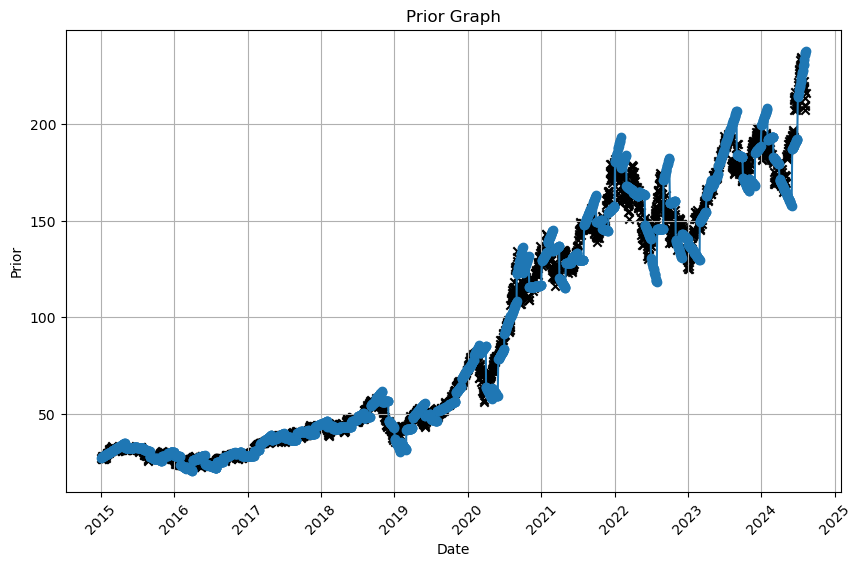

In [10]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(model_df['Date'], model_df['prior_values'], marker='o')
#plt.plot(model_df['Date'], model_df['prior_values'])
plt.scatter(model_df['Date'], model_df['Close'], c='k', marker='x', label='Data')
plt.title('Prior Graph')
plt.xlabel('Date')
plt.ylabel('Prior')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

In [11]:
#Divide The data into train and validation set
model_train2 = model_df[['Date','Close','Date_ordinal','prior_values']].copy()
model_train_subset2 = model_train2[(model_train2['Date'] >= '2015-01-01') & (model_train2['Date'] < '2024-03-01')]
model_train_subset_test2 = model_train2[(model_train2['Date'] >= '2024-03-01') & (model_train2['Date'] <= '2024-03-31')]
model_train_subset2['Date'] = pd.to_datetime(model_train_subset2['Date'])
model_train_subset_test2['Date'] = pd.to_datetime(model_train_subset_test2['Date'])
model_train_subset_test2.head(10)

C:\Users\aman1\AppData\Local\Temp\ipykernel_24032\776334061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset2['Date'] = pd.to_datetime(model_train_subset2['Date'])
C:\Users\aman1\AppData\Local\Temp\ipykernel_24032\776334061.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset_test2['Date'] = pd.to_datetime(model_train_subset_test2['Date'])


,Date,Close,Date_ordinal,prior_values
2405,2024-03-01,179.66,738946,182.846461
2406,2024-03-04,175.10,738949,182.445027
2407,2024-03-05,170.12,738950,182.311215
2408,2024-03-06,169.12,738951,182.177404
2409,2024-03-07,169.00,738952,182.043593
2410,2024-03-08,170.73,738953,181.909781
2411,2024-03-11,172.75,738956,181.508347
2412,2024-03-12,173.23,738957,181.374536
2413,2024-03-13,171.13,738958,181.240725
2414,2024-03-14,173.00,738959,181.106913


In [12]:
#Further transformations of columns to aid in calulations and storing the prior values for training and validation seperately
model_train_final2 = model_train_subset2.copy()
model_train_final_test2 = model_train_subset_test2.copy()

mean = model_train_final2['Date_ordinal'].mean()
std = model_train_final2['Date_ordinal'].std()


prior2 = model_train_final2['prior_values']
prior_test2 = model_train_final_test2['prior_values']

model_train_final2['Date_ordinal_normalized'] = (model_train_final2['Date_ordinal'] - mean)/std
model_train_final_test2['Date_ordinal_normalized'] = (model_train_final_test2['Date_ordinal'] - mean)/std

X_train3 = model_train_final2['Date_ordinal_normalized'].values
y_train3 = model_train_final2['Close'].values

X_test3 = model_train_final_test2['Date_ordinal_normalized'].values
y_test3 = model_train_final_test2['Close'].values

prior_test2

2405    182.846461
2406    182.445027
2407    182.311215
2408    182.177404
2409    182.043593
2410    181.909781
2411    181.508347
2412    181.374536
2413    181.240725
2414    181.106913
2415    180.973102
2416    180.571668
2417    180.437857
2418    180.304046
2419    180.170234
2420    180.036423
2421    179.634989
2422    179.501178
2423    179.367366
2424    179.233555
Name: prior_values, dtype: float64

In [13]:
#Further Transformations
X_obs2 = X_train3
y_obs2 = y_train3

X_obs2 = X_obs2.reshape(-1, 1)

In [14]:
#Finding Optimal parameters through Bayesian method
random.seed(10)
def log_marginal_likelihood(params, X, y, prior_mean):
    length_scale, variance, constant1, constant2 = params
    K = combined_kernel(X, X, length_scale, variance, constant1,constant2) + 1e-3 * np.eye(len(X))  # Add small value for numerical stability
    L = np.linalg.cholesky(K)
    y_centered = y - prior_mean
    S1 = np.linalg.solve(L, y_centered)
    S2 = np.linalg.solve(L.T, S1)
    log_likelihood = -0.5 * np.dot(y_centered.T, S2)
    log_likelihood -= np.sum(np.log(np.diagonal(L)))
    log_likelihood -= 0.5 * len(X) * np.log(2 * np.pi)
    return -log_likelihood  # We minimize negative log likelihood

# Define initial hyperparameters
initial_params = [1.0, 1.0, 1.0,1.0]  # [length_scale, variance, constant1, constant2]

# Optimize hyperparameters
res = minimize(log_marginal_likelihood, initial_params, args=(X_obs2, y_obs2,prior2), bounds=((None, None), (1e-5, None), (1e-5, None) ,(1e-5, None)), method='L-BFGS-B')
optimal_params = res.x

print("Optimal parameters:", optimal_params)

optimized_length_scale = optimal_params[0]
optimized_variance = optimal_params[1]
optimized_constant = optimal_params[2]
optimized_constant2 = optimal_params[3]

Optimal parameters: [0.00180051 1.05998141 0.99999292 0.99999292]


In [15]:
#Calculating Posterior
optimized_length_scale = optimal_params[0]
optimized_variance = optimal_params[1]
optimized_constant = optimal_params[2]
optimized_constant2 = optimal_params[3]


noise = 1e-3
num_samples = 25

# Compute covariance matrices for predictions
K_obs = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
#K_s = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
#K_ss = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs2)))

# Compute the mean and covariance of the posterior
mu_s = prior2 + np.dot(K_s, np.dot(K_obs_inv, (y_obs2 - prior2)))
cov_s = K_ss - np.dot(K_s, np.dot(K_obs_inv, K_s.T))
cov_s_actual = []
mu_s = mu_s.to_numpy()

# Sample from the posterior
L_post = cholesky(cov_s + noise * np.eye(len(X_obs2)), lower=True)
f_post = mu_s.reshape(-1, 1) + np.dot(L_post, np.random.normal(size=(len(X_obs2), num_samples)))

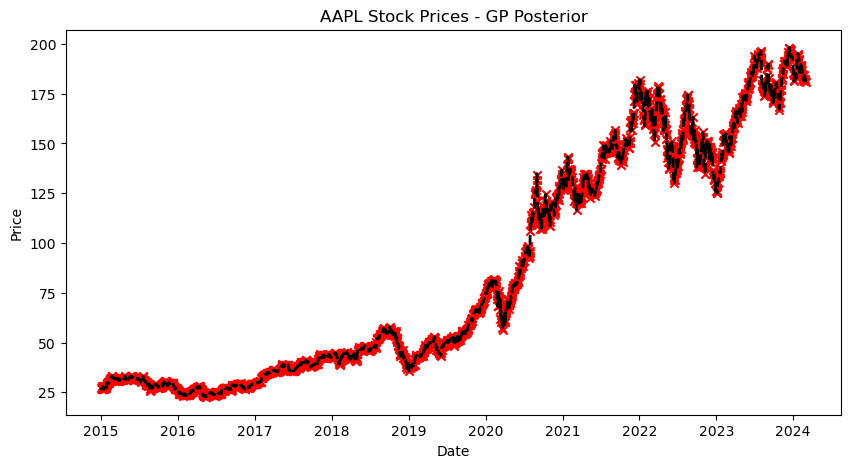

In [17]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
#plt.plot(model_train_final2['Date'], f_post, label="Posterior Samples")
plt.scatter(model_train_final2['Date'], y_obs2, c='red', marker='x', label="Observed Data")
plt.plot(model_train_final2['Date'], mu_s, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(model_train_final2['Date'], 
                 mu_s.flatten() - 1.96 * np.sqrt(np.diag(cov_s)), 
                 mu_s.flatten() + 1.96 * np.sqrt(np.diag(cov_s)), 
                 alpha=0.2, label="95% Confidence Interval")
plt.title("AAPL Stock Prices - GP Posterior")
plt.xlabel("Date")
plt.ylabel("Price")
#plt.legend()
plt.show()

In [18]:
# Compute the covariance vector between the new date and observed dates
K_new = combined_kernel(X_test3.reshape(-1, 1), X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_new_new = combined_kernel(X_test3.reshape(-1, 1), X_test3.reshape(-1, 1), optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)

# Compute the mean and variance of the posterior at the new date
#mu_new = np.dot(K_new, np.dot(K_obs_inv, y_obs))
mu_new = np.dot(K_new, np.dot(K_obs_inv, (y_obs2 - prior2) )) + prior_test2
mu_new = mu_new.to_numpy()
cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))

# Compute the standard deviation
sigma_new = np.sqrt(np.diag(cov_new))

# Print the predicted means and standard deviations
for i in range(len(X_test3)):
    print(f"Predicted mean at new date {X_test3[i]}: {mu_new[i]}")
    print(f"Actual value at new date {X_test3[i]}: {y_test3[i]}")
    print(f"Predicted standard deviation at new date {X_test3[i]}: {sigma_new[i]}")

Predicted mean at new date 1.7339104196097341: 172.52719427196757
Actual value at new date 1.7339104196097341: 179.66
Predicted standard deviation at new date 1.7339104196097341: 0.2762431142878672
Predicted mean at new date 1.7370170074081155: 181.58797179247745
Actual value at new date 1.7370170074081155: 175.1
Predicted standard deviation at new date 1.7370170074081155: 1.0193639229317708
Predicted mean at new date 1.7380525366742425: 182.03770131791703
Actual value at new date 1.7380525366742425: 170.12
Predicted standard deviation at new date 1.7380525366742425: 1.0313183999201834
Predicted mean at new date 1.7390880659403696: 182.03985716313764
Actual value at new date 1.7390880659403696: 169.12
Predicted standard deviation at new date 1.7390880659403696: 1.0322029291720485
Predicted mean at new date 1.7401235952064966: 181.92836884037786
Actual value at new date 1.7401235952064966: 169.0
Predicted standard deviation at new date 1.7401235952064966: 1.0322479414802554
Predicted me

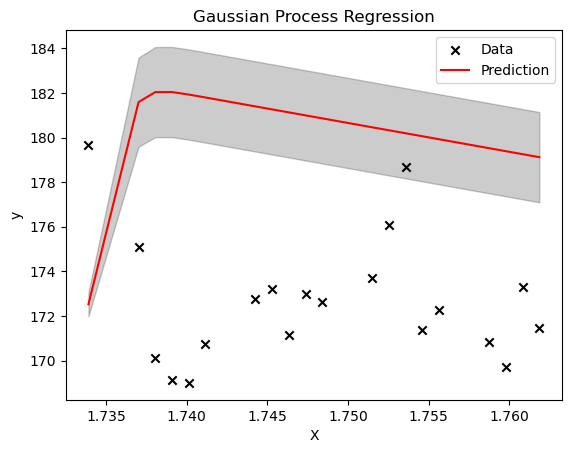

In [19]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure()
plt.scatter(X_test3, y_test3, c='k', marker='x', label='Data')
plt.plot(X_test3, mu_new, c='r', label='Prediction')
#plt.fill_between(X_test2.ravel(),y_test2 + y_test2*0.025, y_test2 - y_test2*0.025, alpha=0.2, color='k')
plt.fill_between(X_test3.ravel(), mu_new - 1.96*sigma_new, mu_new + 1.96*sigma_new, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

In [20]:
#list of values to check for grid search.
optimized_length_scale_list = [x / 20000 for x in range(0, 2001, 5)]
optimized_variance_list = [x / 10 for x in range(0, 1001,5)]

optimized_length_scale_list.remove(0)
optimized_variance_list.remove(0)

In [21]:
#Performing Grid Search normal
dict_scores = {'Length_Scale':[],'Variance':[],'RMSE':[],'RMCE':[],'RMQE':[]}

for optimized_length_scale in optimized_length_scale_list:
    for optimized_variance in optimized_variance_list:
        try:
            noise = 1e-3
            num_samples = 25
            optimized_constant = optimal_params[2]
            optimized_constant2 = optimal_params[3]
            
            K_obs = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
            #K_s = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
            #K_ss = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
            K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs2)))  
            # Compute the covariance vector between the new date and observed dates
            K_new = combined_kernel(X_test3.reshape(-1, 1), X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
            K_new_new = combined_kernel(X_test3.reshape(-1, 1), X_test3.reshape(-1, 1), optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)

            # Compute the mean and variance of the posterior at the new dates
            mu_new = np.dot(K_new, np.dot(K_obs_inv, (y_obs2 - prior2) )) + prior_test2
            mu_new = mu_new.to_numpy()
            #cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))

            # Compute the standard deviation
            #sigma_new = np.sqrt(np.diag(cov_new))
            
            mse = sklearn.metrics.mean_squared_error(y_test3, mu_new)
            mce = np.mean(np.abs(y_test3 - mu_new) ** 3)
            mqe = np.mean(np.abs(y_test3 - mu_new) ** 4)
            dict_scores['Length_Scale'].append(optimized_length_scale)
            dict_scores['Variance'].append(optimized_variance)
            dict_scores['RMSE'].append(mse)
            dict_scores['RMCE'].append(mce)
            dict_scores['RMQE'].append(mqe)
            
        except Exception as e:
            print(f"Error with length scale {optimized_length_scale} and variance {optimized_variance}: {e}")
            continue

In [42]:
#Performing GRID Search with parameters in CUDA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dict_scores = {'Length_Scale':[], 'Variance':[], 'RMSE':[], 'RMCE':[], 'RMQE':[]}

for optimized_length_scale in optimized_length_scale_list:
    for optimized_variance in optimized_variance_list:
        try:
            noise = 1e-3
            num_samples = 25
            optimized_constant = optimal_params[2]
            optimized_constant2 = optimal_params[3]
            
            # Move data to GPU
            X_obs2_torch = torch.tensor(X_obs2, dtype=torch.float32).to(device)
            X_test3_torch = torch.tensor(X_test3, dtype=torch.float32).to(device)
            y_obs2_torch = torch.tensor(y_obs2, dtype=torch.float32).to(device)
            prior2_torch = torch.tensor(prior2.to_numpy(), dtype=torch.float32).to(device)
            prior_test2_torch = torch.tensor(prior_test2.to_numpy(), dtype=torch.float32).to(device)
            
            # Compute kernels
            K_obs = combined_kernel2(X_obs2_torch, X_obs2_torch, optimized_length_scale, optimized_variance, optimized_constant, optimized_constant2)
            K_obs_inv = torch.inverse(K_obs + noise * torch.eye(len(X_obs2_torch)).to(device))
                        
            K_new = combined_kernel2(X_test3_torch.reshape(-1, 1), X_obs2_torch, optimized_length_scale, optimized_variance, optimized_constant, optimized_constant2)
            K_new_new = combined_kernel2(X_test3_torch.reshape(-1, 1), X_test3_torch.reshape(-1, 1), optimized_length_scale, optimized_variance, optimized_constant, optimized_constant2)

            mu_new = torch.matmul(K_new, torch.matmul(K_obs_inv, (y_obs2_torch - prior2_torch))) + prior_test2_torch
            mu_new = mu_new.cpu().numpy()  # Move back to CPU for compatibility with sklearn
            
            mse = sklearn.metrics.mean_squared_error(y_test3, mu_new)
            mce = np.mean(np.abs(y_test3 - mu_new) ** 3)
            mqe = np.mean(np.abs(y_test3 - mu_new) ** 4)
            
            dict_scores['Length_Scale'].append(optimized_length_scale)
            dict_scores['Variance'].append(optimized_variance)
            dict_scores['RMSE'].append(mse)
            dict_scores['RMCE'].append(mce)
            dict_scores['RMQE'].append(mqe)
            
        except Exception as e:
            print(f"Error with length scale {optimized_length_scale} and variance {optimized_variance}: {e}")
            continue

Error with length scale 0.0475 and variance 15.0: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed because the input matrix is singular.
Error with length scale 0.0645 and variance 68.5: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed because the input matrix is singular.
Error with length scale 0.0725 and variance 6.0: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed because the input matrix is singular.
Error with length scale 0.07525 and variance 19.5: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed because the input matrix is singular.
Error with length scale 0.08225 and variance 35.5: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed because the input matrix is singular.
Error with length scale 0.08725 and variance 30.5: linalg.inv: The diagonal element 2305 is zero, the inversion could not be completed beca

In [43]:
df_scores = pd.DataFrame(dict_scores)

In [44]:
# Find the index of the minimum RMSE value
min_rmse_index = df_scores['RMSE'].idxmin()
min_rmce_index = df_scores['RMCE'].idxmin()
min_rmqe_index = df_scores['RMQE'].idxmin()

# Print the row with the lowest RMSE value
print(df_scores.loc[min_rmse_index])
print(df_scores.loc[min_rmce_index])
print(df_scores.loc[min_rmqe_index])

Length_Scale      0.012250
Variance          2.000000
RMSE             11.464257
RMCE             54.469501
RMQE            282.399341
Name: 9603, dtype: float64
Length_Scale      0.012250
Variance          2.000000
RMSE             11.464257
RMCE             54.469501
RMQE            282.399341
Name: 9603, dtype: float64
Length_Scale      0.012250
Variance          2.000000
RMSE             11.464257
RMCE             54.469501
RMQE            282.399341
Name: 9603, dtype: float64


In [89]:
#Checking the fit for validation set with the new found optimal hyperparameters.
optimized_length_scale = 0.012250
optimized_variance = 2.0
optimized_constant = optimal_params[2]
optimized_constant2 = optimal_params[3]

K_obs = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
#K_s = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
#K_ss = combined_kernel(X_obs2, X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs2))) 
            
# Compute the covariance vector between the new date and observed dates
K_new = combined_kernel(X_test3.reshape(-1, 1), X_obs2, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_new_new = combined_kernel(X_test3.reshape(-1, 1), X_test3.reshape(-1, 1), optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)

# Compute the mean and variance of the posterior at the new date
#mu_new = np.dot(K_new, np.dot(K_obs_inv, y_obs))
mu_new = np.dot(K_new, np.dot(K_obs_inv, (y_obs2 - prior2) )) + prior_test2
mu_new = mu_new.to_numpy()
cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))

# Compute the standard deviation
cov_new = cov_new
sigma_new = np.sqrt(np.diag(cov_new))

# Print the predicted means and standard deviations
for i in range(len(X_test3)):
    print(f"Predicted mean at new date {X_test3[i]}: {mu_new[i]}")
    print(f"Actual value at new date {X_test3[i]}: {y_test3[i]}")
    print(f"Predicted standard deviation at new date {X_test3[i]}: {sigma_new[i]}")

Predicted mean at new date 1.7339104196097341: 167.68532021138526
Actual value at new date 1.7339104196097341: 179.66
Predicted standard deviation at new date 1.7339104196097341: 0.041065331168116365
Predicted mean at new date 1.7370170074081155: 160.31189916524454
Actual value at new date 1.7370170074081155: 175.1
Predicted standard deviation at new date 1.7370170074081155: 0.13560924705587982
Predicted mean at new date 1.7380525366742425: 157.74271993029106
Actual value at new date 1.7380525366742425: 170.12
Predicted standard deviation at new date 1.7380525366742425: 0.1821740141572135
Predicted mean at new date 1.7390880659403696: 155.32841865104274
Actual value at new date 1.7390880659403696: 169.12
Predicted standard deviation at new date 1.7390880659403696: 0.23594227614994318
Predicted mean at new date 1.7401235952064966: 153.1874849138694
Actual value at new date 1.7401235952064966: 169.0
Predicted standard deviation at new date 1.7401235952064966: 0.2963914309415859
Predicted

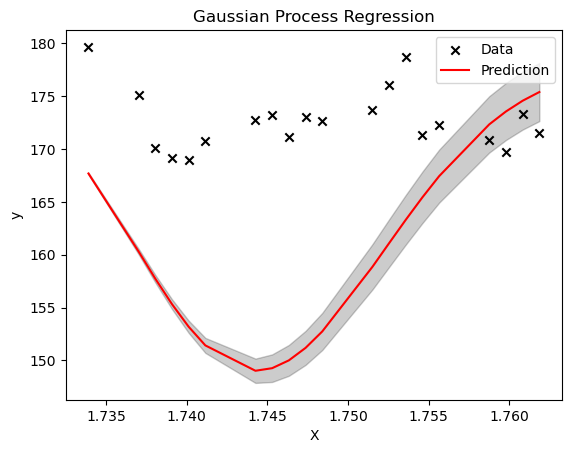

In [90]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure()
plt.scatter(X_test3, y_test3, c='k', marker='x', label='Data')
plt.plot(X_test3, mu_new, c='r', label='Prediction')
#plt.fill_between(X_test2.ravel(),y_test2 + y_test2*0.025, y_test2 - y_test2*0.025, alpha=0.2, color='k')
plt.fill_between(X_test3.ravel(), mu_new - 1.96*sigma_new, mu_new + 1.96*sigma_new, alpha=0.2, color='k')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gaussian Process Regression')
plt.legend()
plt.show()

In [91]:
#Splitting the data into Train and Test set 
model_train3 = model_df[['Date','Close','Date_ordinal','prior_values']].copy()
model_train_subset3 = model_train3[(model_train3['Date'] >= '2015-01-01') & (model_train3['Date'] < '2024-04-01')]
model_train_subset_test3 = model_train3[(model_train2['Date'] >= '2024-04-01') & (model_train3['Date'] <= '2024-04-30')]
model_train_subset3['Date'] = pd.to_datetime(model_train_subset3['Date'])
model_train_subset3['Date_ordinal'] = model_train_subset3['Date'].apply(lambda x: x.toordinal())
model_train_subset_test3['Date'] = pd.to_datetime(model_train_subset_test3['Date'])
model_train_subset_test3['Date_ordinal'] = model_train_subset_test3['Date'].apply(lambda x: x.toordinal()) 
model_train_subset_test3.head(10)

C:\Users\aman1\AppData\Local\Temp\ipykernel_24032\1618671393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset3['Date'] = pd.to_datetime(model_train_subset3['Date'])
C:\Users\aman1\AppData\Local\Temp\ipykernel_24032\1618671393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_train_subset3['Date_ordinal'] = model_train_subset3['Date'].apply(lambda x: x.toordinal())
C:\Users\aman1\AppData\Local\Temp\ipykernel_24032\1618671393.py:8: SettingWithCopyWarning: 
A value is trying to be

,Date,Close,Date_ordinal,prior_values
2425,2024-04-01,170.03,738977,171.441347
2426,2024-04-02,168.84,738978,171.218360
2427,2024-04-03,169.65,738979,170.995374
2428,2024-04-04,168.82,738980,170.772387
2429,2024-04-05,169.58,738981,170.549401
2430,2024-04-08,168.45,738984,169.880441
2431,2024-04-09,169.67,738985,169.657454
2432,2024-04-10,167.78,738986,169.434468
2433,2024-04-11,175.04,738987,169.211481
2434,2024-04-12,176.55,738988,168.988495


In [92]:
model_train_final3 = model_train_subset3.copy()
model_train_final_test3 = model_train_subset_test3.copy()

mean = model_train_final3['Date_ordinal'].mean()
std = model_train_final3['Date_ordinal'].std()

prior3 = model_train_final3['prior_values']
prior_test3 = model_train_final_test3['prior_values']

model_train_final3['Date_ordinal_normalized'] = (model_train_final3['Date_ordinal'] - mean)/std
model_train_final_test3['Date_ordinal_normalized'] = (model_train_final_test3['Date_ordinal'] - mean)/std


X_train4 = model_train_final3['Date_ordinal_normalized'].values
y_train4 = model_train_final3['Close'].values

X_test4 = model_train_final_test3['Date_ordinal_normalized'].values
y_test4 = model_train_final_test3['Close'].values

model_train_final3

,Date,Close,Date_ordinal,prior_values,Date_ordinal_normalized
100,2015-01-02,27.3325,735600,27.374777,-1.730949
101,2015-01-05,26.5625,735603,27.564256,-1.727870
102,2015-01-06,26.5650,735604,27.627415,-1.726843
103,2015-01-07,26.9375,735605,27.690575,-1.725816
104,2015-01-08,27.9725,735606,27.753735,-1.724790
...,...,...,...,...,...
2420,2024-03-22,172.2800,738967,180.036423,1.725600
2421,2024-03-25,170.8500,738970,179.634989,1.728680
2422,2024-03-26,169.7100,738971,179.501178,1.729706
2423,2024-03-27,173.3100,738972,179.367366,1.730733


In [93]:
X_obs3 = X_train4
y_obs3 = y_train4

X_obs3 = X_obs3.reshape(-1, 1)

In [94]:
#Using the Optimal parameters found via GRID Search and Bayesian method
optimized_length_scale = 0.012250
optimized_variance = 2.0
optimized_constant = optimal_params[2]
optimized_constant2 = optimal_params[3]

noise = 1e-3
num_samples = 25

# Compute covariance matrices for predictions
K_obs = combined_kernel(X_obs3, X_obs3, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_s = combined_kernel(X_obs3, X_obs3, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_ss = combined_kernel(X_obs3, X_obs3, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_obs_inv = np.linalg.inv(K_obs + noise * np.eye(len(X_obs3)))

# Compute the mean and covariance of the posterior
mu_s = prior3 + np.dot(K_s, np.dot(K_obs_inv, (y_obs3 - prior3)))
cov_s = K_ss - np.dot(K_s, np.dot(K_obs_inv, K_s.T))
cov_s_actual = []
mu_s = mu_s.to_numpy()

# Sample from the posterior
L_post = cholesky(cov_s + noise * np.eye(len(X_obs3)), lower=True)
f_post = mu_s.reshape(-1, 1) + np.dot(L_post, np.random.normal(size=(len(X_obs3), num_samples)))

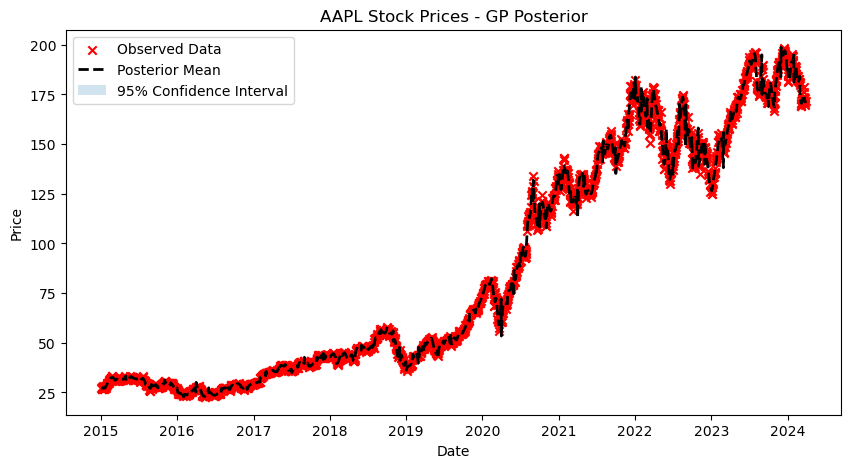

In [102]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Plot samples from the posterior
plt.figure(figsize=(10, 5))
#plt.plot(model_train_final3['Date'], f_post, label="Posterior Samples")
plt.scatter(model_train_final3['Date'], y_obs3, c='red', marker='x', label="Observed Data")
plt.plot(model_train_final3['Date'], mu_s, 'k--', lw=2, label="Posterior Mean")
plt.fill_between(model_train_final3['Date'], 
                 mu_s.flatten() - 1.96 * np.sqrt(np.diag(cov_s)), 
                 mu_s.flatten() + 1.96 * np.sqrt(np.diag(cov_s)), 
                 alpha=0.2, label="95% Confidence Interval")
plt.title("AAPL Stock Prices - GP Posterior")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [96]:
# Compute the covariance vector between the new date and observed dates
K_new = combined_kernel(X_test4.reshape(-1, 1), X_obs3, optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)
K_new_new = combined_kernel(X_test4.reshape(-1, 1), X_test4.reshape(-1, 1), optimized_length_scale, optimized_variance,optimized_constant,optimized_constant2)

# Compute the mean and variance of the posterior at the new date
#mu_new = np.dot(K_new, np.dot(K_obs_inv, y_obs))
mu_new = np.dot(K_new, np.dot(K_obs_inv, (y_obs3 - prior3) )) + prior_test3
cov_new = K_new_new - np.dot(K_new, np.dot(K_obs_inv, K_new.T))
mu_new = list(mu_new)
# Compute the standard deviation
sigma_new = np.sqrt(np.diag(cov_new))

# Print the predicted means and standard deviations
for i in range(len(X_test4)):
    print(f"Predicted mean at new date {X_test4[i]}: {mu_new[i]}")
    print(f"Actual value at new date {X_test4[i]}: {y_test4[i]}")
    print(f"Predicted standard deviation at new date {X_test4[i]}: {sigma_new[i]}")

Predicted mean at new date 1.7358659631269218: 170.1620923254727
Actual value at new date 1.7358659631269218: 170.03
Predicted standard deviation at new date 1.7358659631269218: 0.13265287310248483
Predicted mean at new date 1.7368925593079267: 172.50371034833415
Actual value at new date 1.7368925593079267: 168.84
Predicted standard deviation at new date 1.7368925593079267: 0.17790963724050546
Predicted mean at new date 1.7379191554889315: 175.1317912101381
Actual value at new date 1.7379191554889315: 169.65
Predicted standard deviation at new date 1.7379191554889315: 0.23019186197704722
Predicted mean at new date 1.7389457516699365: 177.9578592764542
Actual value at new date 1.7389457516699365: 168.82
Predicted standard deviation at new date 1.7389457516699365: 0.28902330481466365
Predicted mean at new date 1.7399723478509415: 180.88184356201396
Actual value at new date 1.7399723478509415: 169.58
Predicted standard deviation at new date 1.7399723478509415: 0.3536959909546755
Predicted

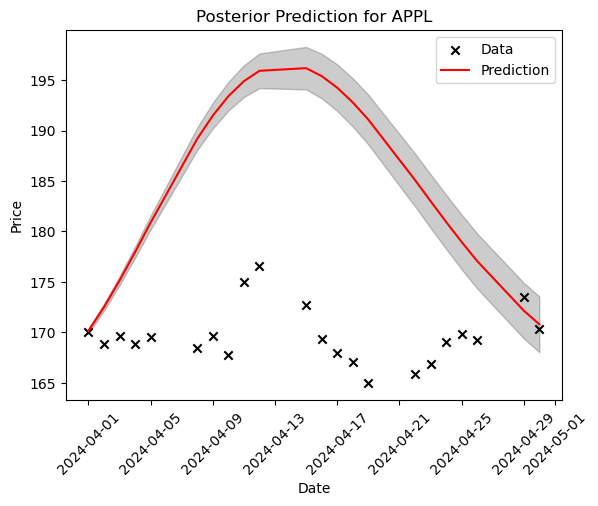

In [97]:
#Final Predictions 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure()
plt.scatter(model_train_final_test3['Date'], y_test4, c='k', marker='x', label='Data')
plt.plot(model_train_final_test3['Date'], mu_new, c='r', label='Prediction')
#plt.fill_between(X_test2.ravel(),y_test2 + y_test2*0.025, y_test2 - y_test2*0.025, alpha=0.2, color='k')
plt.fill_between(model_train_final_test3['Date'], mu_new - 1.96*sigma_new, mu_new + 1.96*sigma_new, alpha=0.2, color='k')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Posterior Prediction for APPL')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [98]:
percentage = []
total = 0
for i in range(len(mu_new)):
    percentage.append((y_test4[i]-mu_new[i])/y_test4[i])
    total = total + abs(percentage[i])
avg_percentage = total/len(percentage)

In [99]:
#Percentage error.
avg_percentage

0.08883277479436935